# Exploratory Analysis and Linear Regression

In [134]:
%matplotlib inline
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.stats.diagnostic import het_white
import random
matplotlib.style.use('ggplot')

In [135]:
md_actor_producer = pd.read_csv("../data/md_actor_producer.csv")
print len(md_actor_producer)

1401


# Adding New Features

In [136]:
# Working with md_actor_producer

# movie_era == 1.0 if year >= 1999, movie_era == 0 if year < 1999
md_actor_producer['movie_era'] = (md_actor_producer['year']>=1999)*1.0

# Joining P and PG ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPGG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

# Joining P, PG, PG-13 ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG') | \
            (md_actor_producer['rating'] == 'PG-13')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

In [137]:
# Grouping genres to categories
def get_genre(s):
    if 'Comedy' in s:
        return 'Comedy+Romance'
    elif 'Action' in s:
        return 'Action+Horror'
    elif 'Drama' in s:
        return 'Drama'
    elif 'Horror' in s:
        return 'Action+Horror'
    elif 'Romance' in s:
        return 'Comedy+Romance'
    elif 'Sci-Fi':
        return 'Sci-Fi'
    else:
        return 'Uncategorized'

def get_genre2(s):
    if 'Comedy' in s:
        return 'Comedy+Romance+Drama'
    elif 'Action' in s:
        return 'Action+Horror+Sci-Fi'
    elif 'Drama' in s:
        return 'Comedy+Romance+Drama'
    elif 'Sci-Fi':
        return 'Action+Horror+Sci-Fi'
    else:
        return 'Uncategorized'
    
md_actor_producer['genre_adj'] = md_actor_producer['genre'].map(lambda s: get_genre(s))
md_actor_producer['genre2'] = md_actor_producer['genre_adj'].map(lambda s: get_genre2(s))

In [138]:
# adjusting for exp effect in theaters
md_actor_producer['theatersdiv1000'] = md_actor_producer.theaters/1000.0
md_actor_producer['theatersdiv1000exp'] = np.exp(md_actor_producer.theatersdiv1000)
# Printing range of theaters/1000 and exp(theaters/1000)
print max(md_actor_producer.theatersdiv1000)
print max(md_actor_producer.theatersdiv1000exp)
print min(md_actor_producer.theatersdiv1000)
print min(md_actor_producer.theatersdiv1000exp)

4.468
87.1821841644
0.005
1.00501252086


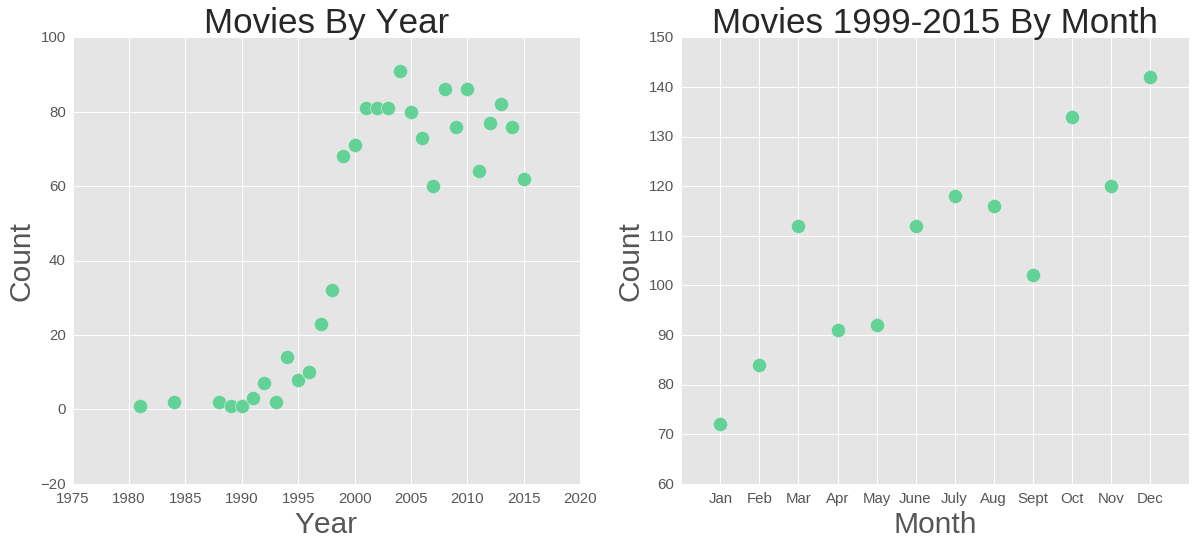

In [139]:
# Simple Analysis 

# BY RATING
# print md_actor_producer.rating.unique()
# print md_actor_producer.groupby("rating").mean().sort_values(by='total_gross', ascending=False)

# BY DIRECTOR
# data_director = md_actor_producer[ pd.notnull(md_actor_producer['director']) ]
# data_director_group = data_director.groupby('director').mean()
# data_director_sorted = data_director_group.sort_values(by='total_gross', ascending = False)

# BY YEAR
size_by_year_actor_prod = md_actor_producer.groupby("year").agg(['count']).reset_index()[['year','movie_title']]
size_by_month_actor_prod = md_actor_producer.groupby("month").agg(['count']).reset_index()[['month','movie_title']]
size_2000 = md_actor_producer[md_actor_producer['year'] >= 1999 ]
size_2000_by_month = size_2000.groupby("month").agg(['count']).reset_index()[['month','movie_title']]
months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
plt.close('all') 
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(size_by_year_actor_prod.year,size_by_year_actor_prod.movie_title,c='#63d297',s=200)
plt.xlabel('Year',fontsize=30)    
plt.ylabel('Count',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Movies By Year', fontsize=35)
plt.subplot(1,2,2)
plt.scatter(size_2000_by_month.month,size_2000_by_month.movie_title,c='#63d297',s=200)
plt.xlabel('Month',fontsize=30)    
plt.ylabel('Count',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(size_2000_by_month.month, months, rotation='horizontal')
plt.title('Movies 1999-2015 By Month',fontsize=35)
plt.xlim(0,13)
plt.savefig('../figs/actorproducer_count_vs_year+month.png') 

In [140]:
# Split the data into training and testing sets
random.seed(123)
train_valid, test = train_test_split(md_actor_producer[ md_actor_producer['movie_era'] == 1], test_size = 0.2)
train, validation = train_test_split(train_valid, test_size = 0.2)
print len(train)
print len(validation)
print len(test)

828
208
259


In [141]:
# Print correlations among selected features in the training set
md_selected = train_valid[['total_gross',
                   'movie_score','runtime',
                   'budget','theatersdiv1000exp',
                   'month','year',
                   'actors_score','producer_score']]
print md_selected.corr()

                    total_gross  movie_score   runtime    budget  \
total_gross            1.000000     0.299814  0.301202  0.621906   
movie_score            0.299814     1.000000  0.358268  0.117277   
runtime                0.301202     0.358268  1.000000  0.387297   
budget                 0.621906     0.117277  0.387297  1.000000   
theatersdiv1000exp     0.755521     0.086047  0.143177  0.688014   
month                  0.037179     0.242081  0.200795  0.031932   
year                   0.034925     0.056300  0.003704 -0.012894   
actors_score           0.353919     0.161022  0.201912  0.332717   
producer_score         0.484740     0.093803  0.183294  0.476730   

                    theatersdiv1000exp     month      year  actors_score  \
total_gross                   0.755521  0.037179  0.034925      0.353919   
movie_score                   0.086047  0.242081  0.056300      0.161022   
runtime                       0.143177  0.200795  0.003704      0.201912   
budget         

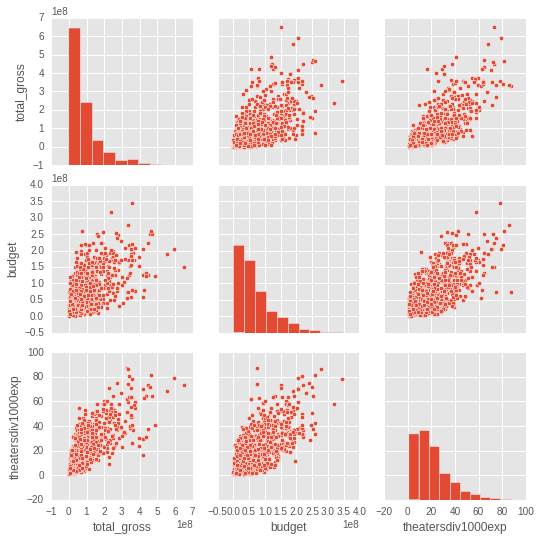

In [142]:
sns.pairplot(md_selected.ix[:,(0,3,4)])
plt.savefig('../figs/corr1.png') 

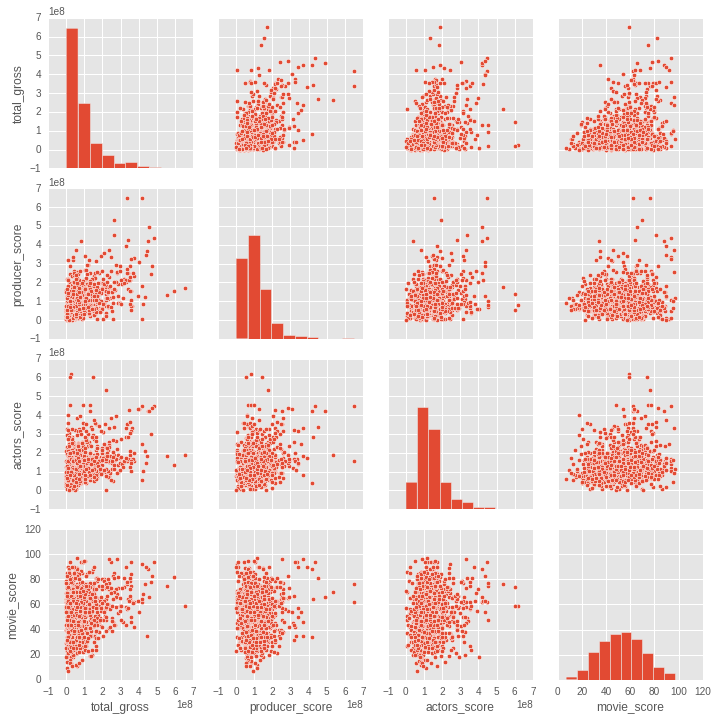

In [143]:
sns.pairplot(md_selected[['total_gross','producer_score','actors_score','movie_score']])
plt.savefig('../figs/corr2.png') 

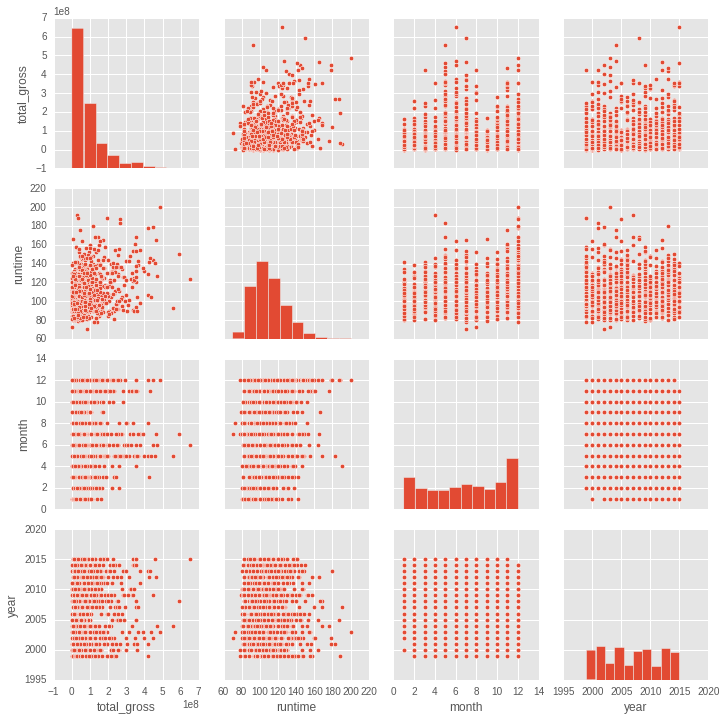

In [144]:
sns.pairplot(md_selected.ix[:,(0,2,5,6)])
plt.savefig('../figs/corr3.png') 

[ 4404458.09003278] [[  5.38058986e+09]]


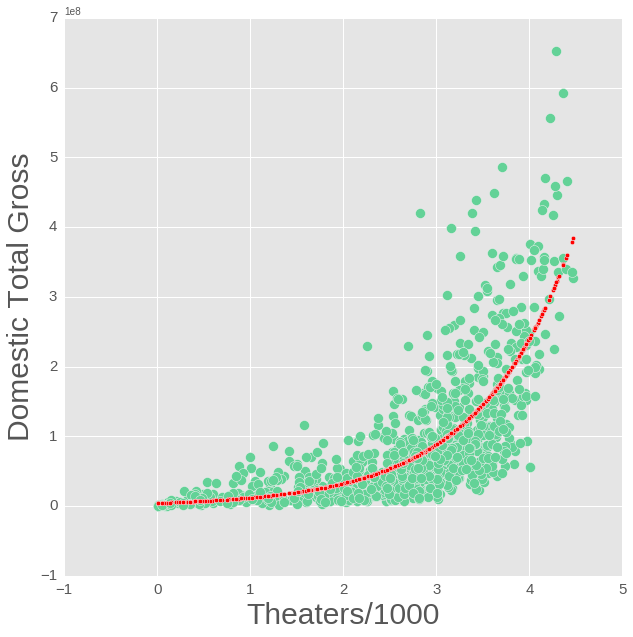

In [145]:
# Modeling Total Gross vs Number of Theaters
from scipy.optimize import curve_fit
def func(x,a):
    return a*np.exp(x)

x = train_valid.theatersdiv1000
y = train_valid.total_gross
popt, pcov = curve_fit(func, x, y)
print popt, pcov
plt.close('all')
plt.figure(figsize = (10,10))
plt.scatter(x,y,c='#63d297',s=100, label="Observed Data")
plt.scatter(x, func(x, *popt), c='red', label="Fitted Curve")
plt.xlabel('Theaters/1000',fontsize=30)    
plt.ylabel('Domestic Total Gross',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../figs/exptheaters.png') 

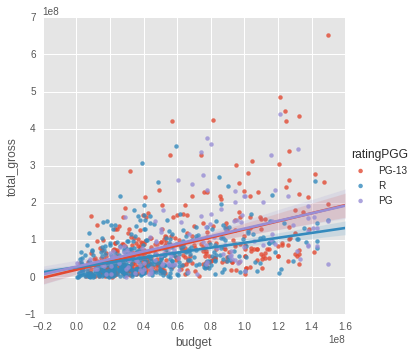

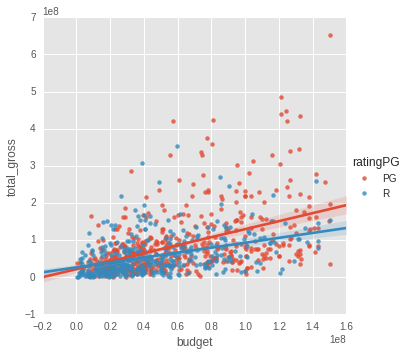

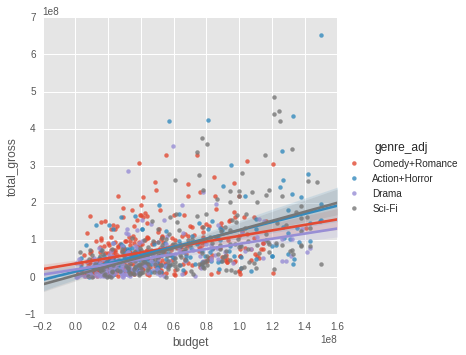

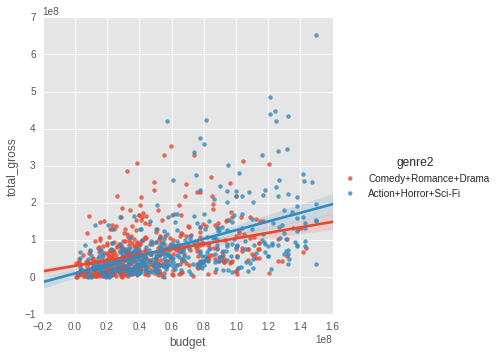

In [146]:
# Total gross vs budget by ratings and genre
plt.close('all')
plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="ratingPGG", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('../figs/gross_vs_budget_byratingPGG.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="ratingPG", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('../figs/gross_vs_budget_byratingPG.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="genre_adj", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('../figs/gross_vs_budget_bygenre.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="genre2", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('../figs/gross_vs_budget_bygenre2.png')

# Linear Regression: Comparing Models 

/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

4.44810290829e+17 0.05
['total_gross' 'movie_score' 'runtime' 'budget' 'theatersdiv1000exp'
 'month' 'year' 'actors_score' 'producer_score' 'ratingR' 'comedy'
 'budget_t_ratingR' 'budget_t_comedy']
[  8.91278575e+07   6.13726501e+07   2.23376295e+07   3.82983092e+08
   1.83721479e+06  -8.04456378e+07   4.54720692e+07   3.72311479e+07
   1.02491845e+06   8.49433715e+06  -9.95602205e-02  -1.30775993e-01]


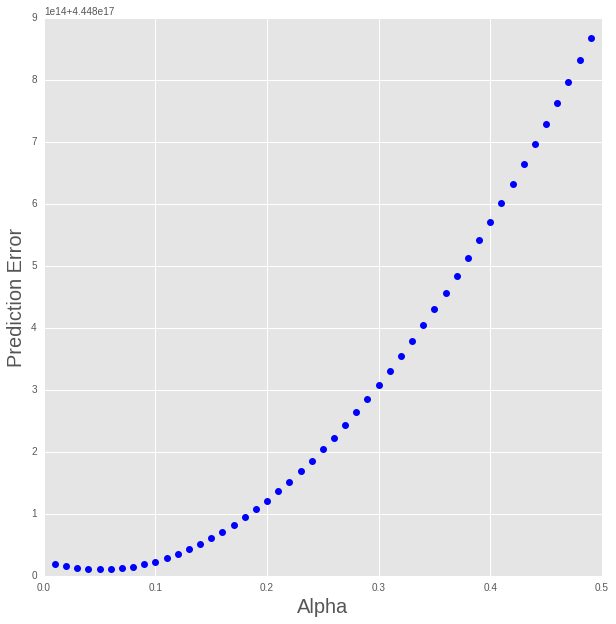

In [147]:
# Split the train+validation set into my_train and my_test sets
# Normalize the dataframe columns
random.seed(123)
md_selected['ratingR'] = (train_valid['ratingPG'] == 'R')*1.0
md_selected['comedy'] = (train_valid['genre2'] == 'Comedy+Romance+Drama')*1.0
md_selected['budget_t_ratingR'] = md_selected['budget']*md_selected['ratingR']
md_selected['budget_t_comedy'] = md_selected['budget']*md_selected['comedy']
my_train, my_test = train_test_split(md_selected, test_size = 0.2)
cols_to_norm = ['movie_score','runtime','budget','theatersdiv1000exp',\
                'month','year','actors_score','producer_score']
my_train[cols_to_norm] = my_train[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
my_test[cols_to_norm] = my_test[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
y = my_train['total_gross']
X = my_train.drop('total_gross',1)
kf = KFold(len(X), n_folds=5)
alphas = np.arange(0.01,0.5,0.01)
prediction_er = []
for alpha in alphas:
    sses = []
    for train_index, test_index in kf:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        #clf = Lasso(alpha=alpha)
        clf = Ridge(alpha=alpha)
        results = clf.fit(X_train, y_train) 
        predictions = results.predict(X_test)
        average = np.mean(y_test)
        sse = np.sum((predictions - y_test)**2.0)
        sses.append(sse)
    total = sum(sses)
    prediction_er.append(total/5.0)

plt.close('all')       
plt.figure(figsize = (10,10))    
plt.plot(alphas,prediction_er,'bo',lw=4)    
plt.xlabel('Alpha',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20)   
print min(prediction_er), alphas[prediction_er.index(min(prediction_er))]
#clf = Lasso(alpha = alphas[prediction_er.index(min(prediction_er))])
clf = Ridge(alpha = alphas[prediction_er.index(min(prediction_er))])
results = clf.fit(X, y) 
print md_selected.columns.values
print results.coef_

##  All coeficients are important, except for : budget x ratingPG AND budget x genre2

# Building Models

In [148]:
def get_summary_noint(s, train, validation, k, drop_list=[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    X_train = X_train.drop('Intercept',1)
    X_valid = X_valid.drop('Intercept',1)
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_train = np.array(y_train.total_gross)
    y_valid = np.array(y_valid.total_gross)
    y_train_ave = np.mean(y_train)*np.ones(len(y_train))
    y_valid_ave = np.mean(y_valid)*np.ones(len(y_valid))
    pred_er = predictions - y_valid
    res = model.resid
    sse_train = np.sum(res**2)
    sse_valid = np.sum(pred_er**2)
    tss_train = np.sum((y_train-y_train_ave)**2)
    tss_valid = np.sum((y_valid-y_valid_ave)**2)
    rsq_noint = 1.0 - (np.mean((y_valid - predictions)**2))/(np.mean(y_valid**2))
    rsq_train = 1.0 - sse_train/tss_train
    rsq_valid = 1.0 - sse_valid/tss_valid
    #http://stats.stackexchange.com/questions/26176/
    #removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo
    m_train = len(y_train)*1.0 # number of points
    m_valid = len(y_valid)*1.0 # number of points
    dfe_train = m_train - k
    dft_train = m_train
    dfe_valid = m_valid - k
    dft_valid = m_valid
    adj_rsq_noint = 1 - ((np.mean((y_valid - predictions)**2))/dfe_valid)/((np.mean(y_valid**2))/dft_valid)
    adj_rsq_train = 1.0 - (sse_train/dfe_train)/(tss_train/dft_train)
    adj_rsq_valid  = 1.0 - (sse_valid/dfe_valid)/(tss_valid/dft_valid)
    print "R squared - no intercept: ", rsq_noint
    print "Adjusted R squared - no intercept: ", adj_rsq_noint
    print "R squared - train: ", rsq_train
    print "Adjusted R squared - train: ", adj_rsq_train
    print "R squared - validation: ", rsq_valid
    print "Adjusted R squared - validation: ", adj_rsq_valid
    return (s, sse_train/len(train), sse_valid/len(validation), adj_rsq_train, adj_rsq_valid)
     
def get_summary(s, train, validation, k, drop_list =[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_train = np.array(y_train.total_gross)
    y_valid = np.array(y_valid.total_gross)
    y_train_ave = np.mean(y_train)*np.ones(len(y_train))
    y_valid_ave = np.mean(y_valid)*np.ones(len(y_valid))
    pred_er = predictions - y_valid
    res = model.resid
    sse_train = np.sum(res**2)
    sse_valid = np.sum(pred_er**2)
    tss_train = np.sum((y_train-y_train_ave)**2)
    tss_valid = np.sum((y_valid-y_valid_ave)**2)
    rsq_train = 1.0 - sse_train/tss_train
    rsq_valid = 1.0 - sse_valid/tss_valid
    #http://stats.stackexchange.com/questions/26176/
    #removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo
    m_train = len(y_train)*1.0 # number of points
    m_valid = len(y_valid)*1.0 # number of points
    dfe_train = m_train - k - 1
    dft_train = m_train - 1
    dfe_valid = m_valid - k - 1
    dft_valid = m_valid - 1 
    adj_rsq_train = 1.0 - (sse_train/dfe_train)/(tss_train/dft_train)
    adj_rsq_valid  = 1.0 - (sse_valid/dfe_valid)/(tss_valid/dft_valid)
    print "R squared - train: ", rsq_train
    print "Adjusted R squared - train: ", adj_rsq_train
    print "R squared - test: ", rsq_valid
    print "Adjusted R squared - test: ", adj_rsq_valid
    return (s, sse_train/len(train), sse_valid/len(validation), adj_rsq_train, adj_rsq_valid)

In [149]:
stats_noint = []
stats_int = []

In [150]:
stats_noint.append(get_summary_noint('total_gross ~ theatersdiv1000exp', train, validation, 1.0))
stats_int.append(get_summary('total_gross ~ theatersdiv1000exp', train, validation, 1.0))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     2855.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          2.00e-270
Time:                        12:06:34   Log-Likelihood:                -15988.
No. Observations:                 828   AIC:                         3.198e+04
Df Residuals:                     827   BIC:                         3.198e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
theatersdiv1000exp  4.329e+06    8.1

In [151]:
stats_noint.append(get_summary_noint('total_gross ~ budget', train, validation, 1.0))
stats_int.append(get_summary('total_gross ~ budget', train, validation, 1.0))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     1655.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          1.43e-199
Time:                        12:06:34   Log-Likelihood:                -16152.
No. Observations:                 828   AIC:                         3.231e+04
Df Residuals:                     827   BIC:                         3.231e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
budget         1.1693      0.029     40.684      0.0

In [152]:
stats_noint.append(get_summary_noint('total_gross ~ budget + producer_score', train, validation, 2.0))
stats_int.append(get_summary('total_gross ~ budget + producer_score', train, validation, 2.0))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     938.9
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          2.05e-213
Time:                        12:06:34   Log-Likelihood:                -16116.
No. Observations:                 828   AIC:                         3.224e+04
Df Residuals:                     826   BIC:                         3.224e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
budget             0.8454      0.046     18.

In [153]:
stats_noint.append(get_summary_noint('total_gross ~ budget + producer_score + actors_score', train, validation, 3.0))
stats_int.append(get_summary('total_gross ~ budget + producer_score + actors_score', train, validation, 3.0))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     647.4
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          3.08e-216
Time:                        12:06:34   Log-Likelihood:                -16106.
No. Observations:                 828   AIC:                         3.222e+04
Df Residuals:                     825   BIC:                         3.223e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
budget             0.7608      0.050     15.

In [154]:
#stats_noint.append(get_summary_noint('total_gross ~ budget + producer_score + actors_score + movie_score', train, validation, 4.0))
#stats_int.append(get_summary('total_gross ~ budget + producer_score + actors_score + movie_score', train, validation, 4.0))

In [155]:
stats_noint.append(get_summary_noint('total_gross ~ producer_score + actors_score + budget*ratingPG', 
                  train, validation, 4.0, ['ratingPG[T.R]']))
stats_int.append(get_summary('total_gross ~ producer_score + actors_score + budget*ratingPG', 
            train, validation, 4.0, ['ratingPG[T.R]']))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     504.1
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          1.11e-219
Time:                        12:06:34   Log-Likelihood:                -16094.
No. Observations:                 828   AIC:                         3.220e+04
Df Residuals:                     824   BIC:                         3.222e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
producer_score           0.1891 

In [156]:
stats_noint.append(get_summary_noint('total_gross ~ producer_score + actors_score + budget*ratingPG + budget*genre2', 
                  train, validation, 5.0, ['ratingPG[T.R]','genre2[T.Comedy+Romance+Drama]']))
stats_int.append(get_summary('total_gross ~ producer_score + actors_score + budget*ratingPG + budget*genre2', 
            train, validation, 5.0, ['ratingPG[T.R]','genre2[T.Comedy+Romance+Drama]']))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     404.9
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          5.71e-219
Time:                        12:06:34   Log-Likelihood:                -16093.
No. Observations:                 828   AIC:                         3.220e+04
Df Residuals:                     823   BIC:                         3.222e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

In [157]:
stats_noint.append(get_summary_noint('total_gross ~ movie_score + runtime + year + theatersdiv1000exp', 
                  train, validation, 4.0))
stats_int.append(get_summary('total_gross ~ movie_score + runtime + year + theatersdiv1000exp', 
            train, validation, 4.0))

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     897.6
Date:                Tue, 26 Apr 2016   Prob (F-statistic):          1.60e-298
Time:                        12:06:34   Log-Likelihood:                -15912.
No. Observations:                 828   AIC:                         3.183e+04
Df Residuals:                     824   BIC:                         3.185e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
movie_score         1.108e+06   1.14

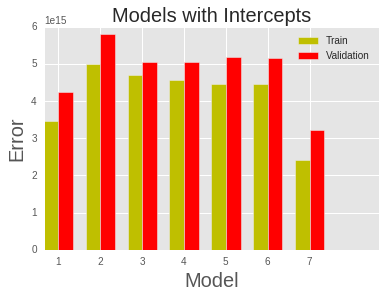

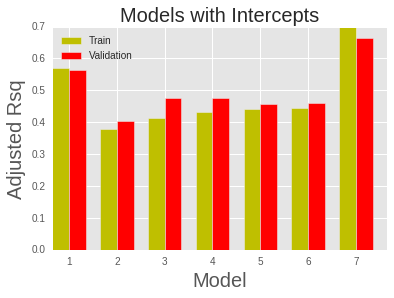

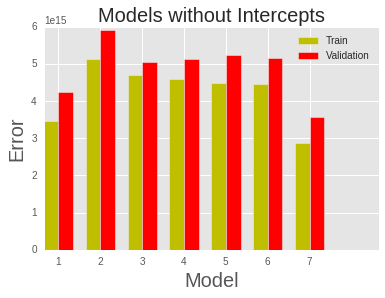

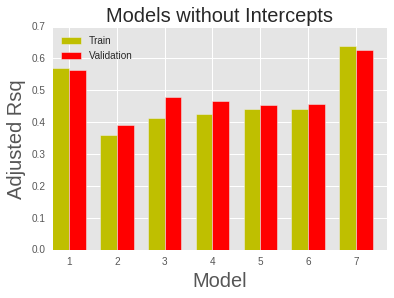

In [160]:
stats_noint_df = pd.DataFrame(stats_noint, columns = ['model','sse_train','sse_valid','adj_rsq_train','adj_rsq_valid'])
stats_int_df = pd.DataFrame(stats_int, columns = ['model','sse_train','sse_valid','adj_rsq_train','adj_rsq_valid'])

plt.close('all')       
plt.figure(figsize = (20,15))  
ind = np.arange(len(stats_int_df))  # the x locations for the groups
width = 0.35                        # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, stats_int_df.sse_train, width, color='y')
rects2 = ax.bar(ind + width, stats_int_df.sse_valid, width, color='r')
# add some text for labels, title and axes ticks
ax.set_xlim(0,len(stats_int_df)+1)
ax.set_ylabel('Error', fontsize=20)
ax.set_xlabel('Model', fontsize=20)
ax.set_title('Models with Intercepts', fontsize=20)
ax.set_xticks(ind + width)
ax.set_xticklabels(range(1,len(stats_int_df)+1))
ax.legend((rects1[0], rects2[0]), ('Train', 'Validation'), loc=1)    
plt.savefig("../figs/sse_vs_model_int.png")
plt.show()

plt.close('all')       
plt.figure(figsize = (20,15))  
ind = np.arange(len(stats_int_df))  # the x locations for the groups
width = 0.35                        # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, stats_int_df.adj_rsq_train, width, color='y')
rects2 = ax.bar(ind + width, stats_int_df.adj_rsq_valid, width, color='r')
# add some text for labels, title and axes ticks
ax.set_xlim(0,len(stats_int_df))
ax.set_ylabel('Adjusted Rsq', fontsize=20)
ax.set_xlabel('Model', fontsize=20)
ax.set_title('Models with Intercepts', fontsize=20)
ax.set_xticks(ind + width)
ax.set_xticklabels(range(1,len(stats_int_df)+1))
ax.legend((rects1[0], rects2[0]), ('Train', 'Validation'),loc=2)   
plt.savefig("../figs/adjrsq_vs_model_int.png")
plt.show()

plt.close('all')       
plt.figure(figsize = (20,15))  
ind = np.arange(len(stats_noint_df))  # the x locations for the groups
width = 0.35                        # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, stats_noint_df.sse_train, width, color='y')
rects2 = ax.bar(ind + width, stats_noint_df.sse_valid, width, color='r')
# add some text for labels, title and axes ticks
ax.set_xlim(0,len(stats_noint_df)+1)
ax.set_ylabel('Error', fontsize=20)
ax.set_xlabel('Model', fontsize=20)
ax.set_title('Models without Intercepts', fontsize=20)
ax.set_xticks(ind + width)
ax.set_xticklabels(range(1,len(stats_noint_df)+1))
ax.legend((rects1[0], rects2[0]), ('Train', 'Validation'), loc=1)    
plt.savefig("../figs/sse_vs_model_noint.png")
plt.show()

plt.close('all')       
plt.figure(figsize = (20,15))  
ind = np.arange(len(stats_noint_df))  # the x locations for the groups
width = 0.35                        # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, stats_noint_df.adj_rsq_train, width, color='y')
rects2 = ax.bar(ind + width, stats_noint_df.adj_rsq_valid, width, color='r')
# add some text for labels, title and axes ticks
ax.set_xlim(0,len(stats_noint_df))
ax.set_ylabel('Adjusted Rsq', fontsize=20)
ax.set_xlabel('Model', fontsize=20)
ax.set_title('Models without Intercepts', fontsize=20)
ax.set_xticks(ind + width)
ax.set_xticklabels(range(1,len(stats_noint_df)+1))
ax.legend((rects1[0], rects2[0]), ('Train', 'Validation'),loc=2)   
plt.savefig("../figs/adjrsq_vs_model_noint.png")
plt.show()

#print stats_int_df.model
#print stats_noint_df.adj_rsq_train
#print stats_noint_df.adj_rsq_valid